# 循环神经网络的从零开始实现
:label:`sec_rnn_scratch`

在本节中，我们将根据 :numref:`sec_rnn` 中的描述，从头开始为字符级语言模型实现循环神经网络。这样的模型将在时光机器数据集上训练。和前面一样，我们首先读取数据集，它在 :numref:`sec_language_model` 中介绍过。


In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 独热编码

回想一下，在`train_iter`中，每个标记都表示为一个数字索引。将这些数字直接输入神经网络可能会使学习变得困难。我们通常将每个标记表示为更具表现力的特征向量。最简单的表示称为“独热编码”（One-Hot Encoding），它在 :numref:`subsec_classification-problem` 中介绍过。

简言之，我们将每个索引映射到一个不同的单位向量：假设词表中不同的标记数为$N$（`len(vocab)`），标记索引的范围为0到$N-1$。如果标记的索引是整数$i$，那么我们创建一个长度为$N$的全0向量，并将$i$处的元素设置为1。此向量是原始标记的一个独热向量。索引为0和2的独热向量如下所示。


In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

我们每次采样的小批量形状是(批量大小, 时间步数)。`one_hot`函数将这样一个小批量转换成三维张量，最后一个维度等于词表大小（`len(vocab)`）。我们经常置换输入的维度，以便获得形状(时间步数, 批量大小, 词汇表大小)的输出。这将使我们能够更方便地通过最外层的维度，一步一步地更新小批量的隐藏状态。


In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## 初始化模型参数

接下来，我们初始化循环神经网络模型的模型参数。隐藏单元数`num_hiddens`是一个可调的超参数。当训练语言模型时，输入和输出来自相同的词表。因此，它们具有相同的维度，即等于词表的大小。


In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 循环神经网络模型

为了定义循环神经网络模型，我们首先需要一个`init_rnn_state`函数在初始化时返回隐藏状态。它返回一个张量，全用0填充，形状为(批量大小, 隐藏单元数)。使用元组可以更容易地处理隐藏状态包含多个变量的情况，我们将在后面的部分中遇到这些情况。


In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

下面的`rnn`函数定义了如何在一个时间步计算隐藏状态和输出。请注意，循环神经网络模型通过最外层维度`inputs`循环，以便逐时间步更新小批量的隐藏状态`H`。此外，这里的激活函数使用$\tanh$函数。如 :numref:`sec_mlp` 所述，当元素在实数上均匀分布时，$\tanh$函数的平均值为0。


In [7]:
def rnn(inputs, state, params):
    # `inputs`的形状：(`时间步数量`, `批量大小`, `词表大小`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # `X`的形状：(`批量大小`, `词表大小`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数，并存储从零开始实现的循环神经网络模型的参数。


In [8]:
class RNNModelScratch:  #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

让我们检查输出是否具有正确的形状，例如，确保隐藏状态的维数保持不变。


In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

我们可以看到输出形状是(时间步数$\times$批量大小, 词汇表大小)，而隐藏状态形状保持不变，即(批量大小, 隐藏单元数)。

## 预测

让我们首先定义预测函数来生成用户提供的`prefix`之后的新字符，`prefix`是一个包含多个字符的字符串。在`prefix`中循环遍历这些开始字符时，我们不断地将隐藏状态传递到下一个时间步，而不生成任何输出。这被称为“预热”（Warm-up）期，在此期间模型会自我更新（例如，更新隐藏状态），但不会进行预测。预热期过后，隐藏状态通常比开始时的初始值好。


In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测`num_preds`步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

现在我们可以测试 `predict_ch8` 函数。我们将前缀指定为 `time traveller ` ，并让它生成10个后续字符。鉴于我们没有训练网络，它会产生荒谬的预测。


In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller gyspfrubdz'

## 梯度裁剪

对于长度为$T$的序列，我们在迭代中计算这些$T$个时间步上的梯度，从而在反向传播过程中产生长度为$\mathcal{O}(T)$的矩阵乘法链。如 :numref:`sec_numerical_stability` 所述，当$T$较大时，它可能导致数值不稳定，例如可能梯度爆炸或梯度消失。因此，循环神经网络模型往往需要额外的帮助来稳定训练。

一般来说，在解决优化问题时，我们对模型参数采取更新步骤，例如在向量形式的$\mathbf{x}$中，在小批量的负梯度$\mathbf{g}$方向上。例如，使用$\eta > 0$作为学习率，在一次迭代中，我们将$\mathbf{x}$更新为$\mathbf{x} - \eta \mathbf{g}$。让我们进一步假设目标函数$f$表现良好，例如，*李卜希兹连续*（Lipschitz continuous）常数$L$。也就是说，对于任意$\mathbf{x}$和$\mathbf{y}$我们有：

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

在这种情况下，我们可以合理地假设，如果我们将参数向量通过$\eta \mathbf{g}$更新，那么：

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

这意味着我们不会观察到超过$L \eta \|\mathbf{g}\|$的变化。这既是诅咒也是祝福。在诅咒的一面，它限制了进步的速度；而在祝福的一面，它限制了如果我们朝着错误的方向前进，事情会出错的程度。

有时梯度可能很大，优化算法可能无法收敛。我们可以通过降低$\eta$的学习率来解决这个问题。但是如果我们很少得到大的梯度呢？在这种情况下，这种做法似乎完全没有根据。一个流行的替代方法是通过将梯度$\mathbf{g}$投影回给定半径的球（例如$\theta$）来裁剪梯度$\mathbf{g}$。如下式：

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

通过这样做，我们知道梯度范数永远不会超过$\theta$，并且更新后的梯度完全与$\mathbf{g}$的原始方向对齐。它还有一个理想的副作用，即限制任何给定的小批量（以及其中任何给定的样本）对参数向量的影响。这赋予了模型一定程度的健壮性。梯度裁剪提供了一个快速修复梯度爆炸的方法。虽然它并不能完全解决问题，但它是众多缓解问题的技术之一。

下面我们定义一个函数来裁剪从零开始实现的模型或由高级API构建的模型的梯度。还要注意，我们计算了所有模型参数的梯度范数。


In [12]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 训练

在训练模型之前，让我们定义一个函数来训练只有一个迭代周期的模型。它与我们训练 :numref:`sec_softmax_scratch` 模型的方式有三个不同之处：

1. 顺序数据的不同采样方法（随机采样和顺序分区）将导致隐藏状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。这确保了即使在训练过程中的某个点上梯度爆炸，模型也不会发散。
1. 我们用困惑度来评价模型。如 :numref:`subsec_perplexity` 所述，这确保了不同长度的序列具有可比性。

具体地说，当使用顺序分区时，我们只在每个迭代周期的开始处初始化隐藏状态。由于下一个小批量中的$i^\mathrm{th}$子序列样本与当前$i^\mathrm{th}$子序列样本相邻，因此当前小批量末尾的隐藏状态将用于初始化下一个小批量开头的隐藏状态。这样，存储在隐藏状态中的序列历史信息可以在一个迭代周期内流过相邻的子序列。然而，任何一点隐藏状态计算都依赖于同一迭代周期中所有的前一个小批量，这使得梯度计算变得复杂。为了降低计算量，我们在处理任何一个小批量之前先分离梯度，使得隐藏状态的梯度计算总是限制在一个小批量的时间步内。

当使用随机抽样时，我们需要为每个迭代周期重新初始化隐藏状态，因为每个样本都是在一个随机位置抽样的。与 :numref:`sec_softmax_scratch` 中的 `train_epoch_ch3` 函数相同，`updater`是更新模型参数的常用函数。它既可以是从头开始实现的 `d2l.sgd` 函数，也可以是深度学习框架中的内置优化函数。


In [13]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 标记数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state`对于`nn.GRU`是个张量
                state.detach_()
            else:
                # `state`对于`nn.LSTM`或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了`mean`函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

训练函数支持从零开始或使用高级API实现的循环神经网络模型。


In [14]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

现在我们可以训练循环神经网络模型。因为我们在数据集中只使用10000个标记，所以模型需要更多的迭代周期来更好地收敛。


困惑度 1.0, 26032.2 标记/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


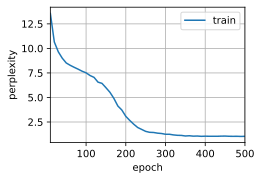

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

最后，让我们检查一下使用随机抽样方法的结果。


KeyboardInterrupt: 

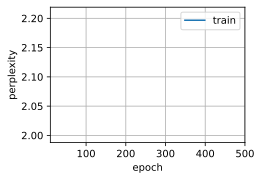

In [16]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

虽然从零开始实现上述循环神经网络模型是有指导意义的，但并不方便。在下一节中，我们将看到如何改进循环神经网络模型，例如，如何使其更易于实现并运行得更快。

## 小结

* 我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本前缀生成文本。
* 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。
* 循环神经网络模型需要状态初始化来训练，尽管随机抽样和顺序划分使用不同的方法。
* 当使用顺序划分时，我们需要分离梯度以减少计算量。
* 预热期允许模型在进行任何预测之前进行自我更新（例如，获得比初始值更好的隐藏状态）。
* 梯度裁剪可以防止渐变爆炸，但不能应对梯度消失。

## 练习

1. 说明独热编码等同于为每个对象选择不同的嵌入。
1. 通过调整超参数（如迭代周期数、隐藏单元数、小批量的时间步数、学习率等）来改善困惑度。
    * 你能降到多低？
    * 用可学习的嵌入替换独热编码。这会带来更好的表现吗？
    * 它在其他书上的效果如何，例如[*星球大战*](http://www.gutenberg.org/ebooks/36)？
1. 修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。
    * 会发生什么？
    * 使模型偏向更可能的输出，例如，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中抽取$\alpha > 1$。
1. 在不裁剪梯度的情况下运行本节中的代码。会发生什么事？
1. 更改顺序划分，使其不会从计算图中分离隐藏状态。运行时间有变化吗？困惑度呢？
1. 用ReLU替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？


[Discussions](https://discuss.d2l.ai/t/2103)
